# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings, _read_pdf, _chunk_texts
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [5]:
from chromadb import Client
from chromadb.config import Settings

# Specify the directory to store the database files
persist_dir = '../Chromadb/'
path_chromadb_dump = '../Chromadb/'

# Create a Chroma client with persistence enabled
client = Client(Settings(is_persistent=True, persist_directory=persist_dir))

# Interact with your collection using the client object
# ... (add, remove, search documents)

# Data gets automatically saved to the persist_dir


In [3]:
import chromadb

def load_chroma(filename, collection_name, embedding_function, persist_directory, is_persisten=True):
    texts = _read_pdf(filename)
    chunks = _chunk_texts(texts)

    # chroma_cliet = chromadb.Client()
    chroma_cliet = chromadb.Client(Settings(is_persistent=True, persist_directory=persist_directory))  
    chroma_collection = chroma_cliet.create_collection(name=collection_name, embedding_function=embedding_function)

    ids = [str(i) for i in range(len(chunks))]

    chroma_collection.add(ids=ids, documents=chunks)

    return chroma_collection

https://docs.trychroma.com/guides

In [ ]:
collection = client.create_collection(name="my_collection", embedding_function=emb_fn)
collection = client.get_collection(name="my_collection", embedding_function=emb_fn)
collection = client.get_collection(name="test", embedding_function=emb_fn) # Get a collection object from an existing collection, by name. Will raise an exception if it's not found.
collection = client.get_or_create_collection(name="test", embedding_function=emb_fn) # Get a collection object from an existing collection, by name. If it doesn't exist, create it.
client.delete_collection(name="my_collection", embedding_function=emb_fn) # Delete a collection and all associated embeddings, documents, and metadata. ⚠️ This is destructive and not reversible


In [ ]:
# embedding_function = SentenceTransformerEmbeddingFunction()
# chroma_collection = client.get_collection(name='microsoft_annual_report_2022', embedding_function=embedding_function)
# chroma_collection.count()

In [6]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = client.get_or_create_collection(name='microsoft_annual_report_2022', embedding_function=embedding_function) # Get a collection object from an existing collection, by name. If it doesn't exist, create it.

# chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function, persist_directory=persist_dir)
# chroma_collection.count()

In [7]:
import os
import openai
import sys
sys.path.append('../..')
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('.env\my_api_key.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()



In [8]:
from py3810.myUtils import pickle_dump, pickle_load

# embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)

Don't run next cell if embeddings, umap_transform, projected_dataset_embeddings are loaded

In [ ]:
# import umap.umap_ as umap
# import numpy as np
# from tqdm import tqdm
# from py3810.myUtils import pickle_dump, pickle_load

# embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
# umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
# projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# pickle_dump(file_to_pickle=embeddings, filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
# pickle_dump(file_to_pickle=umap_transform, filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
# pickle_dump(file_to_pickle=projected_dataset_embeddings, filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [9]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [10]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Yes, during the
fiscal year, there was notable turnover in the executive team with the
departure of the Chief Financial Officer and the Chief Operating
Officer. The organization conducted a thorough search process and
successfully filled these positions with experienced professionals to
continue driving the company's strategic vision forward.


In [11]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

the company engaged deloitte & touche llp, an independent registered
public accounting firm, to audit and render an opinion on the
consolidated financial statements and internal control over financial
reporting in accordance with the standards of the public company
accounting oversight board ( united states ). the board of directors,
through its audit committee, consisting solely of independent directors
of the company, meets periodically with management, internal auditors,
and our independent registered public accounting firm to ensure that
each is meeting its responsibilities and to discuss matters concerning
internal controls and financial reporting. deloitte & touche llp and
the internal auditors each have full and free access to the audit
committee. satya nadella chief executive officer amy e. hood executive
vice president and chief financial officer alice l. jolla corporate
vice president and chief accounting officer

84 report of independent registered public accounting firm to 

In [12]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

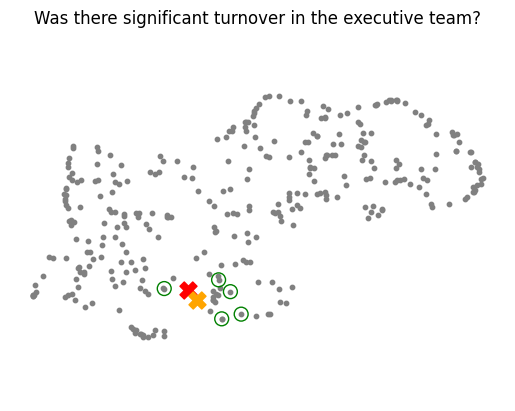

In [13]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [14]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [15]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did sales volume impact revenue growth?
- What new products or services contributed to revenue growth?
- Did any acquisitions or mergers impact revenue growth?
- How did pricing strategies affect revenue growth?
- Were there any changes in market demand that influenced revenue growth?


In [17]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [18]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


In [19]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [01:16<00:00,  2.54s/it]


(-0.4267502035945654,
 10.904596148058772,
 5.316428327560425,
 11.376193857192993)

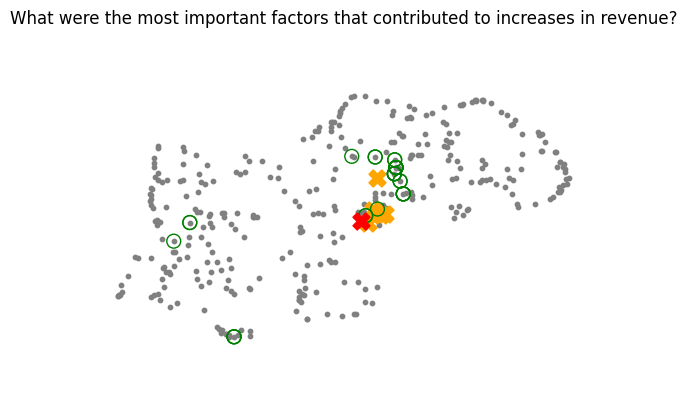

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')